FFR 120  
Felix Waldschock

HW 2  
Exercise 7.6

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','grid'])
from tqdm import trange


In [63]:
# Simulation parameters
L = 100                                     # length of the box
sigma = 1       
dT = 0.01
dT = 1

N = 20                                      # number of trajectiories (particles)
T_tot = [10000]                             # total time
T_tot = np.array(T_tot)
Iteration_Steps = T_tot * (1 / dT)          # total number of steps 
max_steps = int(np.max(Iteration_Steps))    # maximum number of steps


# parameters
n_drift = 10
n_diff = 2


x0 = 0          # initial position of the particle
alpha = 1
sigma0 = 1
dSigma = 1.8 

numberOfIntervalls = 100
Lk = L / numberOfIntervalls
IntervallCenters = np.linspace(0, (numberOfIntervalls-1)*Lk, numberOfIntervalls) + Lk/2 - L/2


In [64]:
def getDrift(displacement):
    displacement = np.mean(displacement, axis=0)
    return displacement / (n_drift * dT)

In [65]:
def getDiff(displacement):
    displacement = np.mean(displacement, axis=0)
    return (displacement**2) / (2 * n_diff * dT)

In [66]:
# constant noise simulation ex 7.2, create a trajectory matrix containing trajectories of all particles

def simulate_trajectory_constant(N, max_steps, L):
    x = np.zeros(N)*x0
    
    trajectories = np.zeros((N, len(T_tot)))                             # array to store trajectories  
    sigmas_ = np.zeros(N)                                                # array to store sigmas
        
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        # calc new sigma
        o = sigma * np.sqrt(dT)
        directions = np.random.choice([-1, 1], N)
        x += directions * o
        
        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)
        
        trajectoryTensor[:,s] = x
    
    trajectories[:, -1] = x
    sigmas_[:] = sigma

    
    return trajectories, sigmas_, trajectoryTensor

In [67]:
# multiplicative noise 
def simulate_trajectory_multiplicative(N, max_steps, L, alpha):
    x = np.ones(N)*x0

    trajectories = np.zeros((N, len(T_tot)))                            # array to store trajectories  
    sigmas_ = np.zeros(N)                                               # array to store sigmas
 
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        
        # get new noise
        sigma = np.zeros(N)
        # multiplicative noise
        tmp1 = sigma0 + dSigma*x/L
        tmp2 = dSigma * dT / L
        tmp3 = tmp1 * np.sqrt(dT)
        direction = np.random.choice([-1,1], N)
        sigma = alpha * tmp1 * tmp2 + tmp3 * direction
        
        x += sigma

        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)

        trajectoryTensor[:,s] = x

    
        if s in Iteration_Steps:
            index = np.where(Iteration_Steps == s)[0][0]
            trajectories[:, index] = x

        

    trajectories[:, -1] = x
    sigmas_ = sigma

    return trajectories, sigmas_, trajectoryTensor


In [68]:
# Run constant simulation
trajectories_constant, sigmas_constant, trajectoryTensor_constant = simulate_trajectory_constant(N, max_steps, L)


100%|██████████| 10000/10000 [00:00<00:00, 68705.36it/s]


In [69]:
# Run multiplicative simulation
trajectories_multiplicative, sigmas_multiplicative, trajectoryTensor_multiplicative = simulate_trajectory_multiplicative(N, max_steps, L, alpha)

100%|██████████| 10000/10000 [00:00<00:00, 49827.08it/s]


In [70]:
def computeDriftDiff(trajectoryTensor):
    # if a particle is in an intervall, check where it is after n_drift steps, use this difference to getDrift
    drift = np.zeros(numberOfIntervalls)
    driftCounter = np.zeros(numberOfIntervalls)
    diff = np.zeros(numberOfIntervalls)
    diffCounter = np.zeros(numberOfIntervalls)

    # trajecoryTensor comes in dimension (N, max_steps)
    numP = trajectoryTensor.shape[0]
    numSteps = trajectoryTensor.shape[1]

    # loop over all particles
    for t in trange(numP-1):
        # loop over all time steps
            for s in range(numSteps-n_drift-1):
                currentParticle = trajectoryTensor[t, s]
                # check from which intervallCenter the particle lays < Lk/2 away
                intervallIndex = np.where(np.abs(currentParticle - IntervallCenters) < Lk/2)

                # check where the particle is after n_drift steps and add to drift array, increment counter
                #print(trajectoryTensor[t,s+n_drift])
                driftDifference = trajectoryTensor[t,s+n_drift] - currentParticle
                diffDifference = trajectoryTensor[t,s+n_diff] - currentParticle

                #newDrift = getDrift(driftDifference)
                #newDiff = getDiff(diffDifference)
                drift[intervallIndex] += driftDifference
                driftCounter[intervallIndex] += 1
                diff[intervallIndex] += diffDifference
                diffCounter[intervallIndex] += 1

    
    # average the drift and diffusion
    drift = drift/driftCounter
    diff = diff**2 
    diff = diff/diffCounter

    # implement the formulas 7.13 / 7.14
    drift = drift/(n_drift * dT)
    diff = diff/(n_diff * dT*2)

    # if nan set to zero  
    drift[np.isnan(drift)] = 0
    diff[np.isnan(diff)] = 0

    return drift, driftCounter, diff, diffCounter

In [71]:
# compute the drift and diffusion for both simulation trajectories

drift_constant, driftCounter_const, diffusion_constant, diffCounter_const = computeDriftDiff(trajectoryTensor_constant)
drift_multiplicative, driftCounter_mult, diffusion_multiplicative, diffCounter_mult = computeDriftDiff(trajectoryTensor_multiplicative)



100%|██████████| 19/19 [00:00<00:00, 22.99it/s]
/var/folders/gt/mfl3krb11tg0vm1rn1bxgmfh0000gn/T/ipykernel_238/2027691685.py:34: RuntimeWarning: invalid value encountered in divide
  drift = drift/driftCounter
/var/folders/gt/mfl3krb11tg0vm1rn1bxgmfh0000gn/T/ipykernel_238/2027691685.py:36: RuntimeWarning: invalid value encountered in divide
  diff = diff/diffCounter
100%|██████████| 19/19 [00:01<00:00, 17.41it/s]


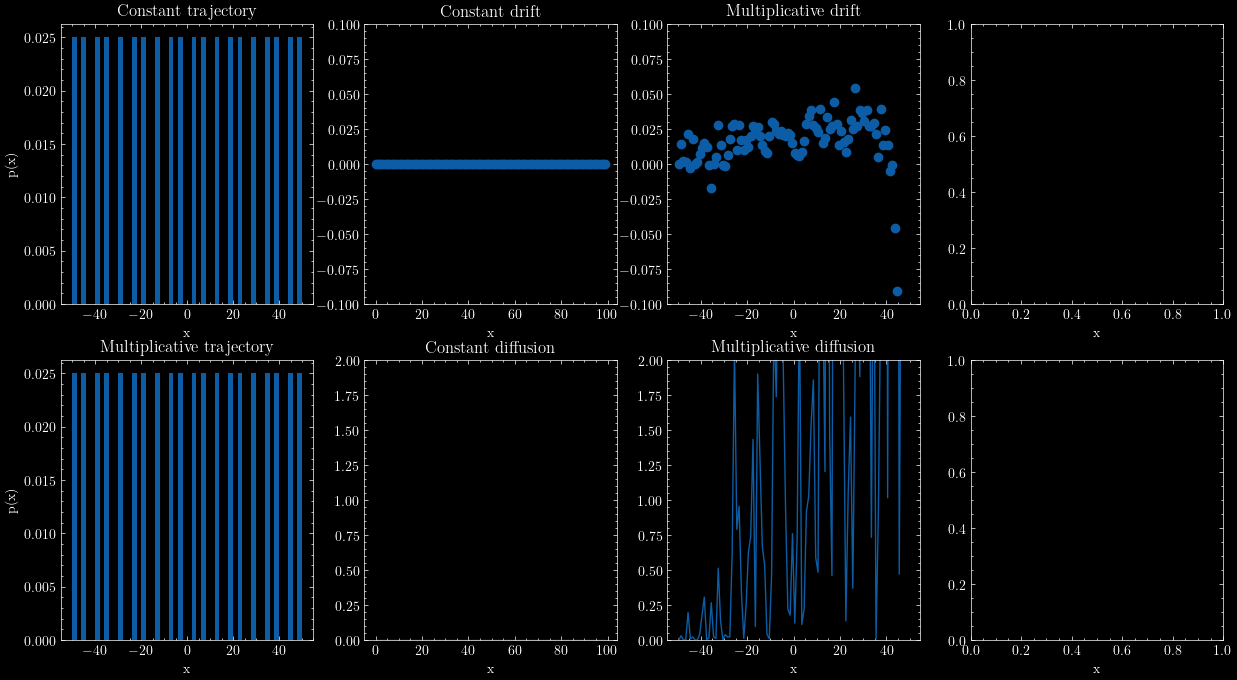

In [72]:
# plot a 2x3 subplot
fig, axs = plt.subplots(2, 4, figsize=(15,8))
x_init = np.linspace(-L/2, L/2, N)


# plot the constantDrift and conStantDiffusion in 1 and 2
axs[0, 0].hist(x_init, bins=50, density=True, label='constant drift')
axs[0, 0].set_title('Constant trajectory')
axs[0, 0].set(ylabel='p(x)')

axs[1, 0].hist(x_init, bins=50, density=True, label='multiplicative trajectory')
axs[1, 0].set_title('Multiplicative trajectory')
axs[1, 0].set(ylabel='p(x)')

axs[0, 1].plot(drift_constant, 'o',label='constant noise')
axs[0, 1].set_title('Constant drift')
axs[0, 1].set_ylim(-0.1, 0.1)
axs[1, 1].plot(diffusion_constant, label='constant noise')
axs[1, 1].set_title('Constant diffusion')
axs[1, 1].set_ylim(-0, 2)


axs[0, 2].plot(IntervallCenters,drift_multiplicative, 'o', label='multiplicative noise')
axs[0, 2].set_title('Multiplicative drift')
axs[0, 2].set_ylim(-0.1, 0.1)
axs[1, 2].plot(IntervallCenters,diffusion_multiplicative, label='multiplicative noise')
axs[1, 2].set_title('Multiplicative diffusion')
axs[1, 2].set_ylim(-0, 2)


# set x label for all plots "x"
for ax in axs.flat:
    ax.set(xlabel='x')

In [73]:
print(diffusion_constant)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
